In [449]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/tan_drive')


Drive already mounted at /content/tan_drive; to attempt to forcibly remount, call drive.mount("/content/tan_drive", force_remount=True).


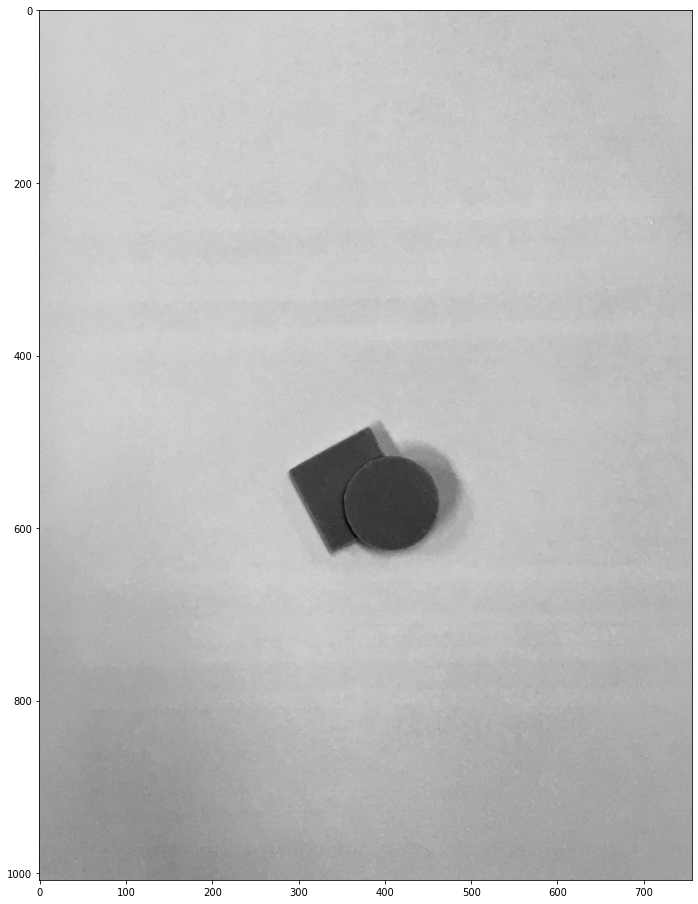

In [450]:
# read image through command line
img = cv2.imread("/content/tan_drive/MyDrive/Transfer file iphone2cpt/IMG_8612.JPG") #15 vuong tren tron, 12 tron tren vuong, 10 vuong tren vuong
h, w = int(img.shape[0]), int(img.shape[1])

ratio = w/h
start_point =(400,900) #x,y
h_cut = 2700

img = img[start_point[1]:start_point[1]+h_cut,start_point[0]:start_point[0]+int(h_cut*ratio)] # cut follow y:y+h,x:x+w
img = cv2.resize(img, (w//4,h//4))
use = cv2.medianBlur(img.copy(),11)
plt.figure(figsize=(12,16))
plt.imshow(img[...,1],cmap='gray')



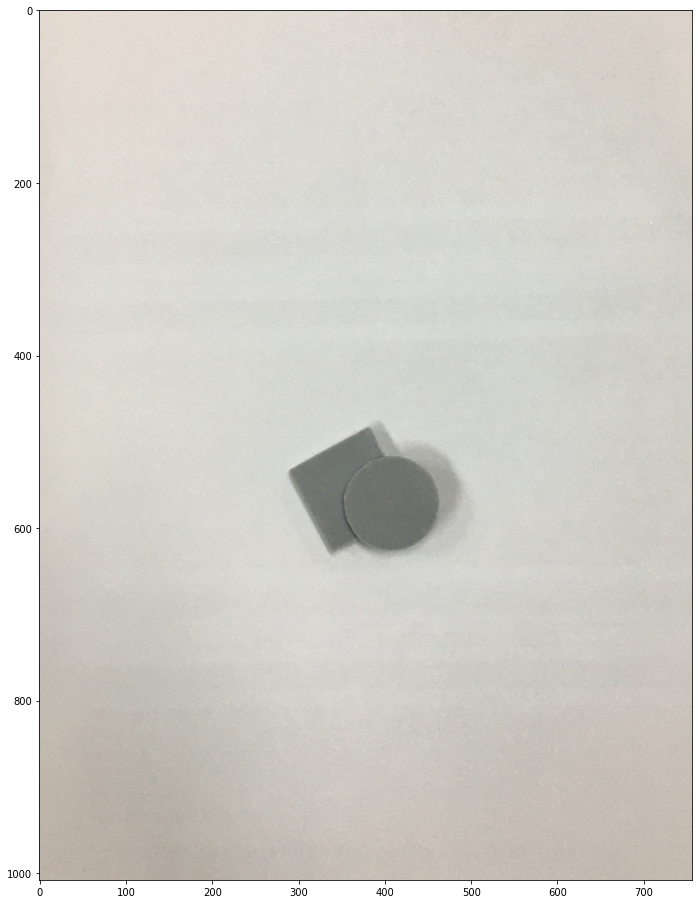

In [451]:
plt.figure(figsize=(12,16))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

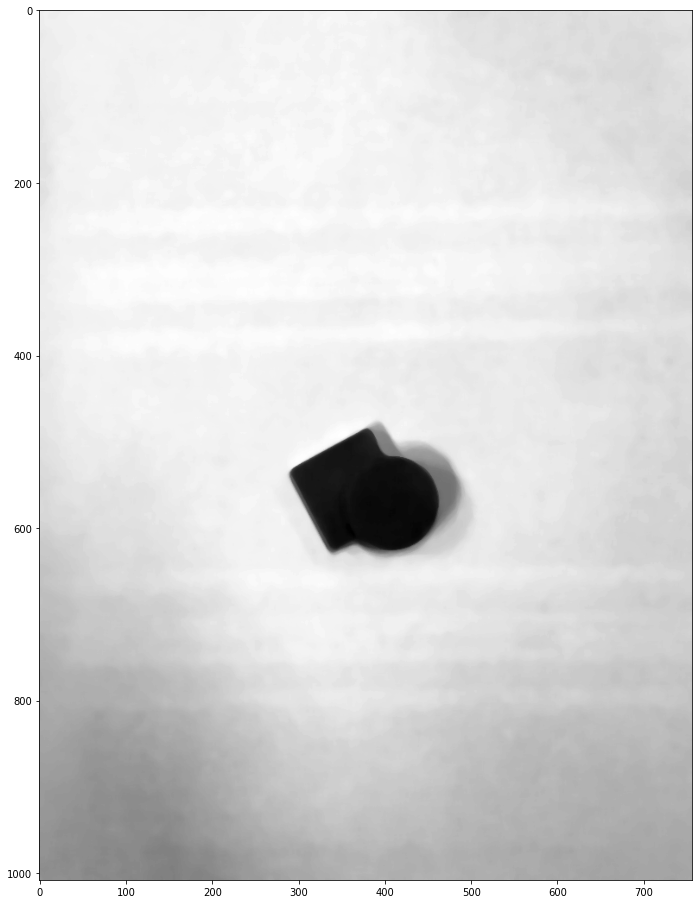

In [452]:
# convert the image to grayscale
gray_image = use[...,0]
plt.figure(figsize=(12,16))
plt.imshow(gray_image,cmap='gray')

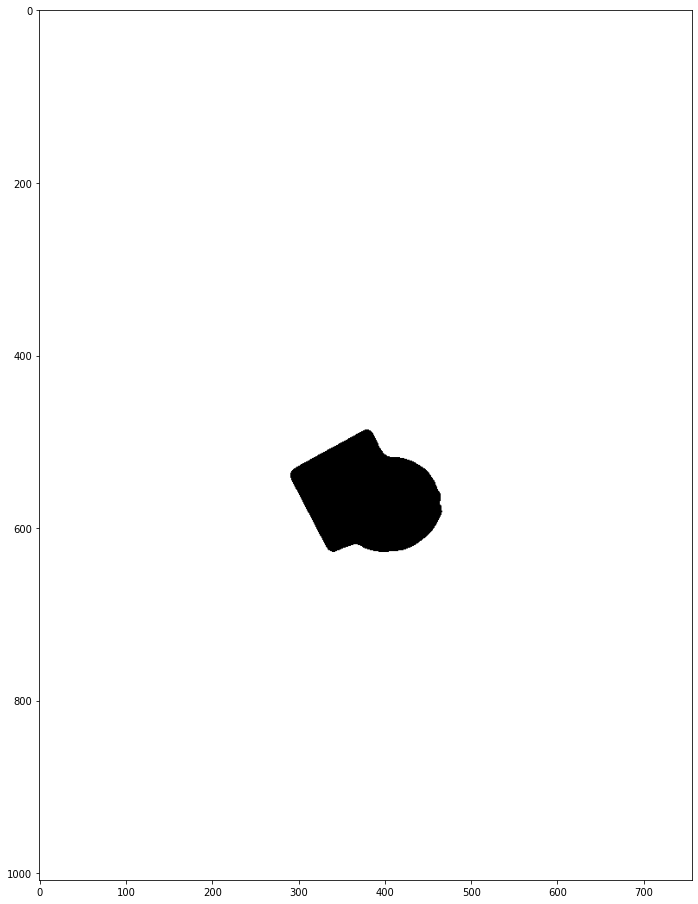

In [453]:
# convert the grayscale image to binary image
ret,thresh = cv2.threshold(gray_image,150,255,0)
thresh = cv2.dilate(thresh, (2,2), iterations=1)
# thresh = cv2.Canny(gray_image, 30, 200)
plt.figure(figsize=(12,16))
plt.imshow(thresh,cmap='gray')

In [454]:
# find contours in the binary image
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [455]:
for cnt in contours:
  print(cv2.contourArea(cnt))

760285.0
17051.5


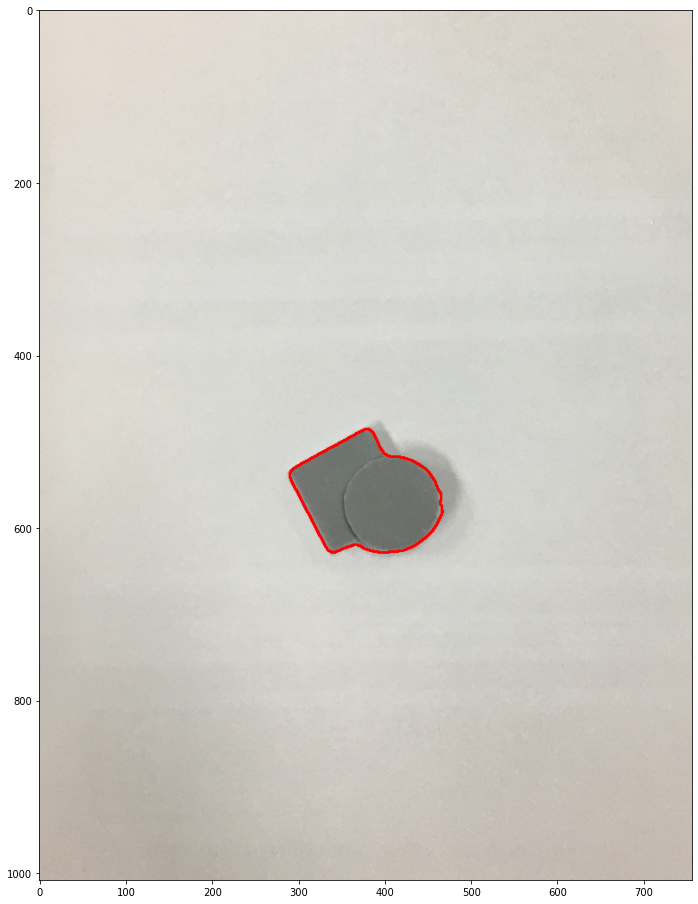

In [456]:
cnts = [cnt for cnt in contours if cv2.contourArea(cnt) >= 7000 and cv2.contourArea(cnt) < 26000 ]
vd = img.copy()
cv2.drawContours(vd,cnts,-1,(0,0,255),2)
plt.figure(figsize=(12,16))
plt.imshow(cv2.cvtColor(vd,cv2.COLOR_BGR2RGB))

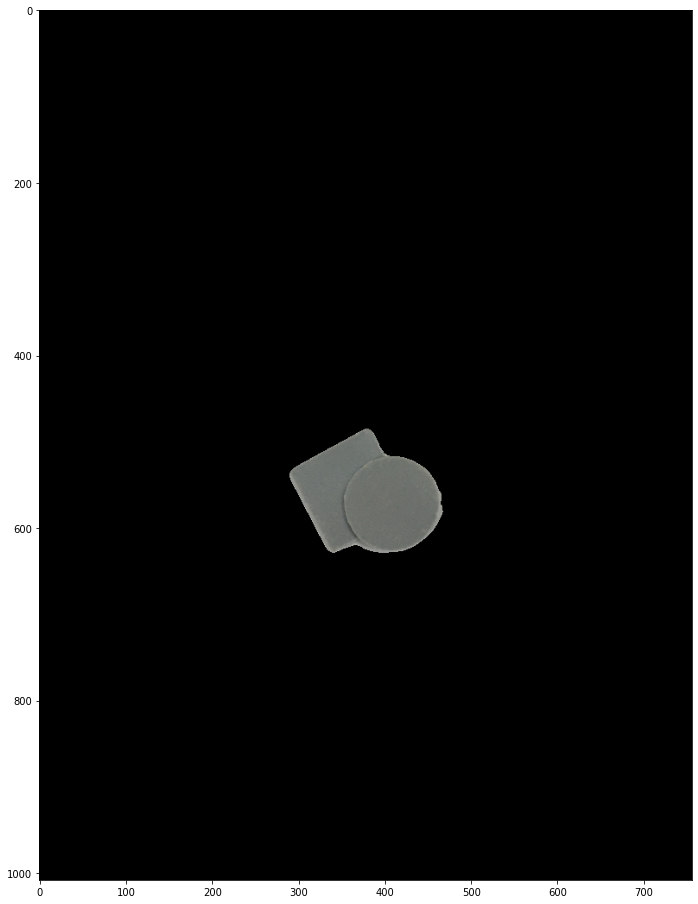

In [457]:
mask = np.zeros_like(img)

cv2.drawContours(mask,cnts,-1,(255,255,255),-1) #draw filled contours in mask
out = np.zeros_like(img)
out[mask ==255] =img[mask==255]
plt.figure(figsize=(12,16))
plt.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB))

In [458]:
final = img.copy()
for c in cnts:
     # calculate moments for each contour
    (x,y,w,h) = cv2.boundingRect(c)
    # print(x,y,w,h)

    # calculate x,y coordinate of center
    if x > 0 and w > 30:
        try:
            cv2.rectangle(final, (x,y),(x+w, y+h), (0,255,0), 2)
            M = cv2.moments(c)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(final, (cX, cY), 5, (0, 0, 255), -1)
            cv2.putText(final, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        except:
            continue

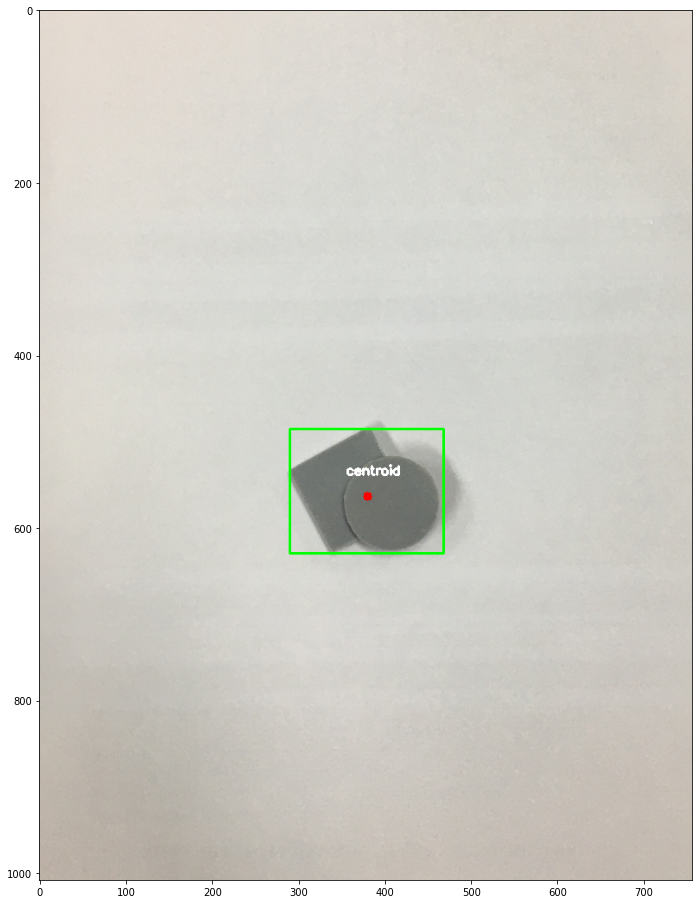

In [459]:
plt.figure(figsize=(12,16))
plt.imshow(cv2.cvtColor(final,cv2.COLOR_BGR2RGB))


<font size="12px">Detect <code> Circle </code> </font>




In [460]:
circles	= cv2.HoughCircles(use[...,1],cv2.HOUGH_GRADIENT,1,120,param1=100,param2=30,minRadius=0,maxRadius=0)
circles	= np.uint16(np.around(circles))

In [461]:
cir_img = img.copy()
for cir in circles[0,:]:
  center =(cir[0],cir[1])
  cv2.circle(cir_img,center,1,(0,255,0),3)
  cv2.putText(cir_img,"ctr",(cir[0]-10,cir[1]-10),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
  radius = cir[2]
  cv2.circle(cir_img,center,radius,(255,0,255),3)

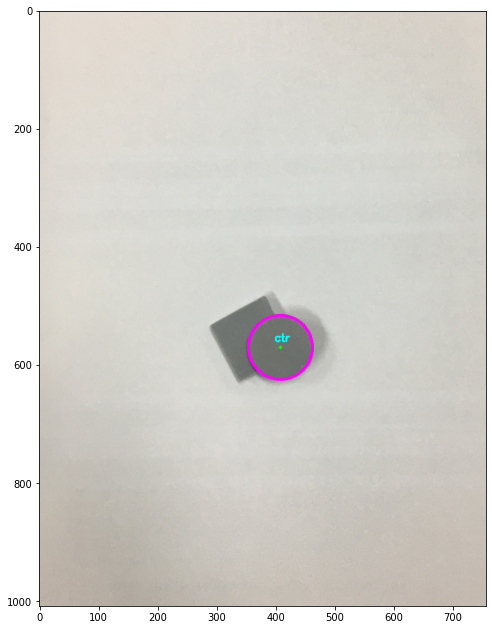

In [462]:
plt.figure(figsize=(8,12))
plt.imshow(cv2.cvtColor(cir_img,cv2.COLOR_BGR2RGB))

<font size="12px">Detect <code> Retangle </code> </font>

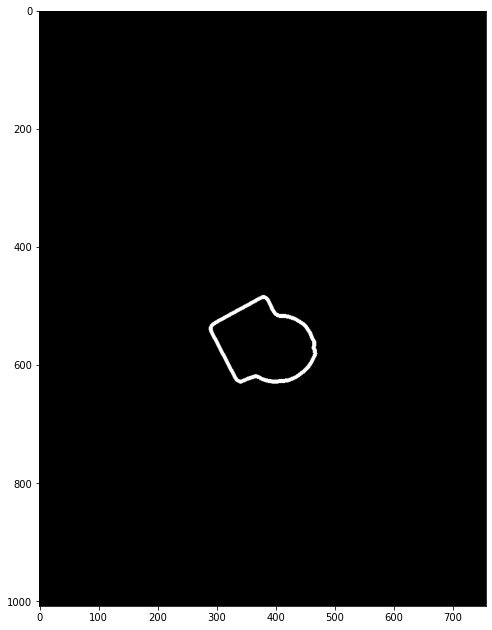

In [463]:
import math
mask_white = np.zeros_like(img).astype(np.uint8)
cv2.drawContours(mask_white,cnts,-1,(255,255,255),5)
# mask_white = cv2.dilate(mask_white,None,iterations=2)
# mask_white = cv2.erode(mask_white,None,iterations=1)
mask_white = mask_white[...,0]
plt.figure(figsize=(8,12))
plt.imshow(mask_white,cmap='gray')

12


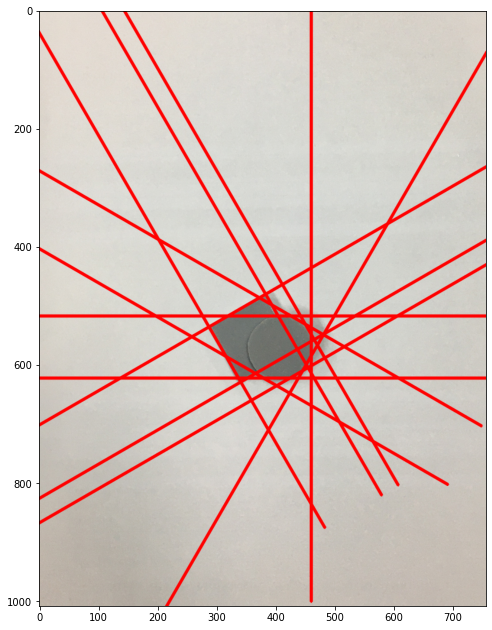

In [464]:
lines = cv2.HoughLines(mask_white,3,np.pi/6,110,None,0,0)

line_img = img.copy()
if lines is not None:
  for i in range(0,len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(line_img, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
  print(len(lines))
plt.figure(figsize=(8,12))
plt.imshow(cv2.cvtColor(line_img,cv2.COLOR_BGR2RGB))



<br>

<font size="8px">New method </font>
<br>
<br><br><br>


In [475]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import argparse
import imutils
import cv2
image = cv2.imread("/content/tan_drive/MyDrive/Transfer file iphone2cpt/IMG_8609.JPG")
h,w = image.shape[0:2]
image = image[900:3600,400:2400]
image = cv2.resize(image,(w//8,h//8))

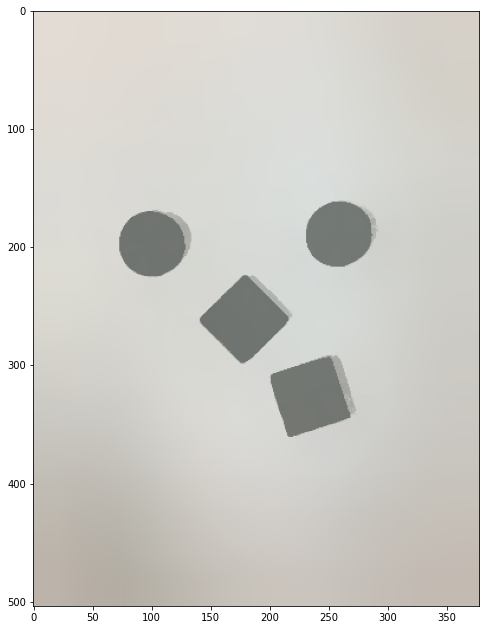

In [476]:
image = cv2.GaussianBlur(image,(3,3),None)
shifted = cv2.pyrMeanShiftFiltering(image, 21,51)
# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.figure(figsize=(8,12))
plt.imshow(cv2.cvtColor(shifted,cv2.COLOR_BGR2RGB))

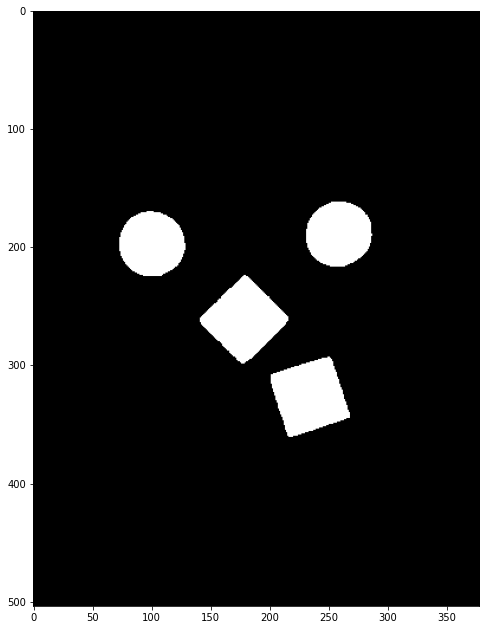

In [477]:
if thresh[0,0] == 255:
  thresh = 255 - thresh
plt.figure(figsize=(8,12))
plt.imshow(cv2.cvtColor(thresh,cv2.COLOR_BGR2RGB))

In [478]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)  # compute matrix distance to correlate peak
localMax = peak_local_max(D, indices=False, min_distance=10, labels=thresh) # find each local maximum (center)
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0] #use to make connect between pixel and label to object
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))


[INFO] 4 unique segments found


<ipython-input-478-3de99a2233aa>:5: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=10, labels=thresh) # find each local maximum (center)
/usr/local/lib/python3.8/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


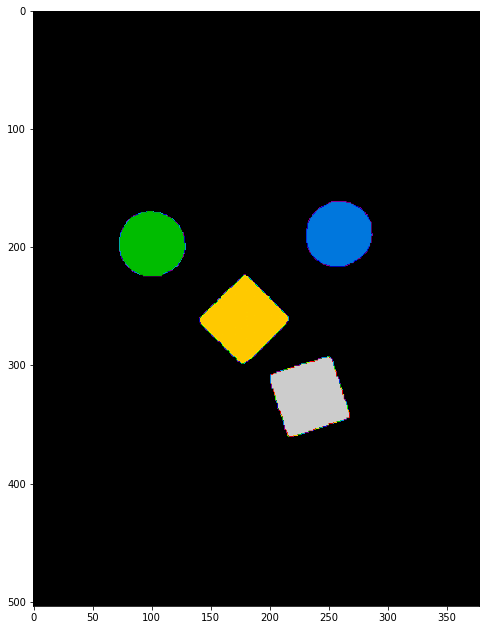

In [479]:
plt.figure(figsize=(8,12))
plt.imshow(labels, cmap=plt.cm.nipy_spectral)


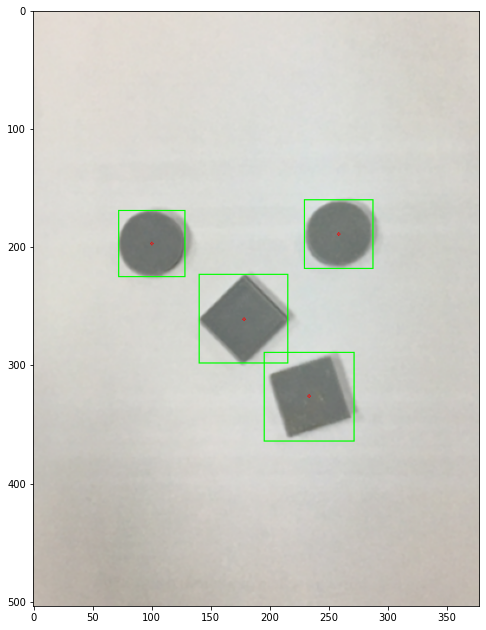

In [480]:
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
  # if the label is zero, we are examining the 'background'
  # so simply ignore it
  if label == 0:
    continue
  # otherwise, allocate memory for the label region and draw
  # it on the mask
  mask = np.zeros(gray.shape, dtype="uint8")
  mask[labels == label] = 255
  # detect contours in the mask and grab the largest one
  cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  # draw a circle enclosing the object
  ((x, y), r) = cv2.minEnclosingCircle(c)
  cv2.circle(image, (int(x), int(y)), 1, (0, 0, 255), 1)
  cv2.rectangle(image,(int(x-r), int(y-r)),(int(x+r), int(y+r)),(0,255,0),1)
  # cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
plt.figure(figsize=(8,12))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))


In [481]:
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray, (7,7),0)

# # circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, h/2,
# #                           param1=100, param2=30,
# #                           minRadius=1, maxRadius=30)
# cny = cv2.Canny(gray ,70,120,apertureSize=3,L2gradient=1)
# plt.figure(figsize=(8,12))
# plt.imshow(cny,cmap='gray')

In [482]:
# # convert the grayscale image to binary image
# ret,thresh = cv2.threshold(gray_image,150,255,0)
# thresh = cv2.dilate(thresh, (1,1), iterations=1)
# # thresh = cv2.Canny(gray_image, 30, 200)
# plt.figure(figsize=(8,12))
# plt.imshow(thresh,cmap='gray')
# plt.show()